In [4]:
import struct
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
def parse_ideal_line(path):
    with open(path, "rb") as f:
        version = struct.unpack("<i", f.read(4))[0]
        if version != 7:
            raise ValueError(f"Unsupported spline version: {version}")

        point_count = struct.unpack("<i", f.read(4))[0]
        lap_time = struct.unpack("<i", f.read(4))[0]
        sample_count = struct.unpack("<i", f.read(4))[0]

        # AiPoint: position (vec3), length, id
        points = []
        for _ in range(point_count):
            x, y, z = struct.unpack("<fff", f.read(12))
            length = struct.unpack("<f", f.read(4))[0]
            point_id = struct.unpack("<i", f.read(4))[0]
            points.append([x, y, z, length, point_id])

        extra_count = struct.unpack("<i", f.read(4))[0]
        if extra_count != point_count:
            raise ValueError("Mismatch between point count and extra data count.")

        # AiPointExtra: 18 floats = 72 bytes
        extras = []
        for _ in range(extra_count):
            data = struct.unpack("<" + "f" * 18, f.read(72))
            extras.append(list(data))

    columns = [
        "x", "y", "z", "length", "id",
        "speed", "gas", "brake", "obsolete_lat_g", "radius",
        "side_left", "side_right", "camber", "direction",
        "normal_x", "normal_y", "normal_z",
        "extra_length",
        "forward_x", "forward_y", "forward_z",
        "tag", "grade"
    ]

    df = pd.DataFrame([p + e for p, e in zip(points, extras)], columns=columns)
    return df

def parse_kn5_road_vertices(kn5_path, road_keywords=None):
    """
    Extracts road-related mesh vertices from a .kn5 file.
    Filters meshes by material or shader names using keywords.
    """
    if road_keywords is None:
        road_keywords = ["road", "asphalt", "track", "surface", "pitlane", "curb"]

    with open(kn5_path, "rb") as f:
        magic = f.read(6)
        version = struct.unpack("<I", f.read(4))[0]

        if version > 5:
            f.read(4)  # skip extra header if present

        # TEXTURES
        texture_count = struct.unpack("<i", f.read(4))[0]
        for _ in range(texture_count):
            f.read(4)  # texture type
            name_len = struct.unpack("<i", f.read(4))[0]
            f.read(name_len)
            tex_size = struct.unpack("<i", f.read(4))[0]
            f.read(tex_size)

        # MATERIALS
        material_count = struct.unpack("<i", f.read(4))[0]
        materials = []
        for _ in range(material_count):
            name_len = struct.unpack("<i", f.read(4))[0]
            name = f.read(name_len).decode("utf-8").lower()
            shader_len = struct.unpack("<i", f.read(4))[0]
            shader = f.read(shader_len).decode("utf-8").lower()
            f.read(2)  # unknown short
            if version > 4:
                f.read(4)
            prop_count = struct.unpack("<i", f.read(4))[0]
            for _ in range(prop_count):
                pname_len = struct.unpack("<i", f.read(4))[0]
                f.read(pname_len)
                f.read(4)
                f.read(36)
            sample_count = struct.unpack("<i", f.read(4))[0]
            for _ in range(sample_count):
                sname_len = struct.unpack("<i", f.read(4))[0]
                f.read(sname_len)
                f.read(4)
                tname_len = struct.unpack("<i", f.read(4))[0]
                f.read(tname_len)
            materials.append((name, shader))

        # MESHES
        mesh_vertices = []

        def matches_road(mat_name, shader_name):
            return any(k in mat_name for k in road_keywords) or any(k in shader_name for k in road_keywords)

        def read_string():
            strlen = struct.unpack("<i", f.read(4))[0]
            return f.read(strlen).decode("utf-8")

        def read_vec3():
            return struct.unpack("<3f", f.read(12))

        def read_node():
            node_type = struct.unpack("<i", f.read(4))[0]
            name = read_string()
            child_count = struct.unpack("<i", f.read(4))[0]
            f.read(1)

            if node_type == 1:  # Dummy node
                f.read(64)
            elif node_type in [2, 3]:  # Mesh or Animated Mesh
                f.read(3)
                vertex_count = struct.unpack("<i", f.read(4))[0]
                positions = []
                for _ in range(vertex_count):
                    pos = read_vec3()
                    f.read(12 + 8 + 12)  # skip normals, UVs, tangents
                    positions.append(pos)
                idx_count = struct.unpack("<i", f.read(4))[0]
                f.read(idx_count * 2)  # indices
                mat_id = struct.unpack("<i", f.read(4))[0]
                f.read(29 if node_type == 2 else 12)

                if 0 <= mat_id < len(materials):
                    mat_name, shader = materials[mat_id]
                    if matches_road(mat_name, shader):
                        mesh_vertices.extend(positions)

            for _ in range(child_count):
                read_node()

        read_node()

    return pd.DataFrame(mesh_vertices, columns=["x", "y", "z"])


def estimate_track_edges(kn5_path, spline_df, offset=6):
    """
    Projects points perpendicular to the racing line, snaps to nearest road mesh vertex.
    Returns left/right edge DataFrame with timestamp.
    """
    mesh_df = parse_kn5_road_vertices(kn5_path)
    mesh_tree = KDTree(mesh_df[["x", "z"]].values)

    left_pts = []
    right_pts = []

    for i in range(1, len(spline_df) - 1):
        x1, y1 = spline_df.iloc[i - 1][["x", "z"]]
        x2, y2 = spline_df.iloc[i + 1][["x", "z"]]
        dx, dy = x2 - x1, y2 - y1
        norm = np.hypot(dx, dy)
        if norm == 0:
            continue

        perp = np.array([-dy, dx]) / norm
        cx, cy = spline_df.iloc[i][["x", "z"]]
        left_query = np.array([cx, cy]) + perp * offset
        right_query = np.array([cx, cy]) - perp * offset

        _, left_idx = mesh_tree.query(left_query)
        _, right_idx = mesh_tree.query(right_query)

        left_pts.append(mesh_df.iloc[left_idx].values)
        right_pts.append(mesh_df.iloc[right_idx].values)

    return pd.DataFrame({
        "timestamp": np.arange(len(left_pts)),
        "left_x": [pt[0] for pt in left_pts],
        "left_y": [pt[1] for pt in left_pts],
        "left_z": [pt[2] for pt in left_pts],
        "right_x": [pt[0] for pt in right_pts],
        "right_y": [pt[1] for pt in right_pts],
        "right_z": [pt[2] for pt in right_pts],
    })


In [6]:
map = "../data/assetto_corsa_tracks/ks_nurburgring/"
versions_ideal = {"gp_a":("layout_gp_a/data/ideal_line.ai", "layout_gp_a/map.png"), "gp_b":("layout_gp_b/data/ideal_line.ai", "layout_gp_b/map.png"),
                  "sprint_a":("layout_sprint_a/data/ideal_line.ai", "layout_sprint_a/map.png"), "sprint_b": ("layout_sprint_b/data/ideal_line.ai", "layout_sprint_b/map.png")}
versions_ai = {"gp_a":("layout_gp_a/ai/fast_lane.ai", "layout_gp_a/map.png"), "gp_b":("layout_gp_b/ai/fast_lane.ai", "layout_gp_b/map.png"),
                  "sprint_a":("layout_sprint_a/ai/fast_lane.ai", "layout_sprint_a/map.png"), "sprint_b": ("layout_sprint_b/ai/fast_lane.ai", "layout_sprint_b/map.png")}
kn5_path = "../data/assetto_corsa_tracks/ks_nurburgring/ks_nurburgring.kn5"

name = "gp_a" # gp_a, gp_b, sprint_a, sprint_b
ideal_line_path = map + versions_ai[name][0] 
image_path = map + versions_ai[name][1]

racing_df = parse_ideal_line(ideal_line_path)
edges_df = estimate_track_edges(kn5_path, racing_df, offset=6) # Play with estimate_track_edges to get better results, could also play with offset.

In [7]:
edges_df.info()
edges_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3305 entries, 0 to 3304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3305 non-null   int64  
 1   left_x     3305 non-null   float64
 2   left_y     3305 non-null   float64
 3   left_z     3305 non-null   float64
 4   right_x    3305 non-null   float64
 5   right_y    3305 non-null   float64
 6   right_z    3305 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 180.9 KB


,timestamp,left_x,left_y,left_z,right_x,right_y,right_z
0,0,-10.808666,63.535656,-760.655457,-2.243481,63.710495,-761.752136
1,1,-10.806805,63.533989,-760.359009,-2.234417,63.701916,-760.264282
2,2,-10.804943,63.532318,-760.062683,-2.221752,63.690678,-758.193298
3,3,-12.277111,63.481644,-757.132446,-2.214550,63.685810,-757.018005
4,4,-12.269787,63.473228,-755.965027,-2.207500,63.681076,-755.849060


In [8]:
def plot_track_edges_with_map(
    edge_df,
    map_image_path=None,
    offset=(0, 0),
    scale=1.0,
    title="Track Edges + Map"
):
    fig, ax = plt.subplots(figsize=(16, 16), dpi=150)

    # Plot background map image if provided
    if map_image_path:
        img = Image.open(map_image_path)
        w, h = img.size
        extent = [
            offset[0], offset[0] + w * scale,
            offset[1] + h * scale, offset[1]
        ]
        ax.imshow(img, extent=extent, origin="upper", alpha=0.6)

    # Plot left and right edges
    ax.plot(edge_df["left_x"], edge_df["left_z"], color="blue", label="Left Edge", linewidth=0.8)
    ax.plot(edge_df["right_x"], edge_df["right_z"], color="red", label="Right Edge", linewidth=0.8)

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_aspect("equal")
    ax.legend()
    plt.grid(True)
    plt.show()


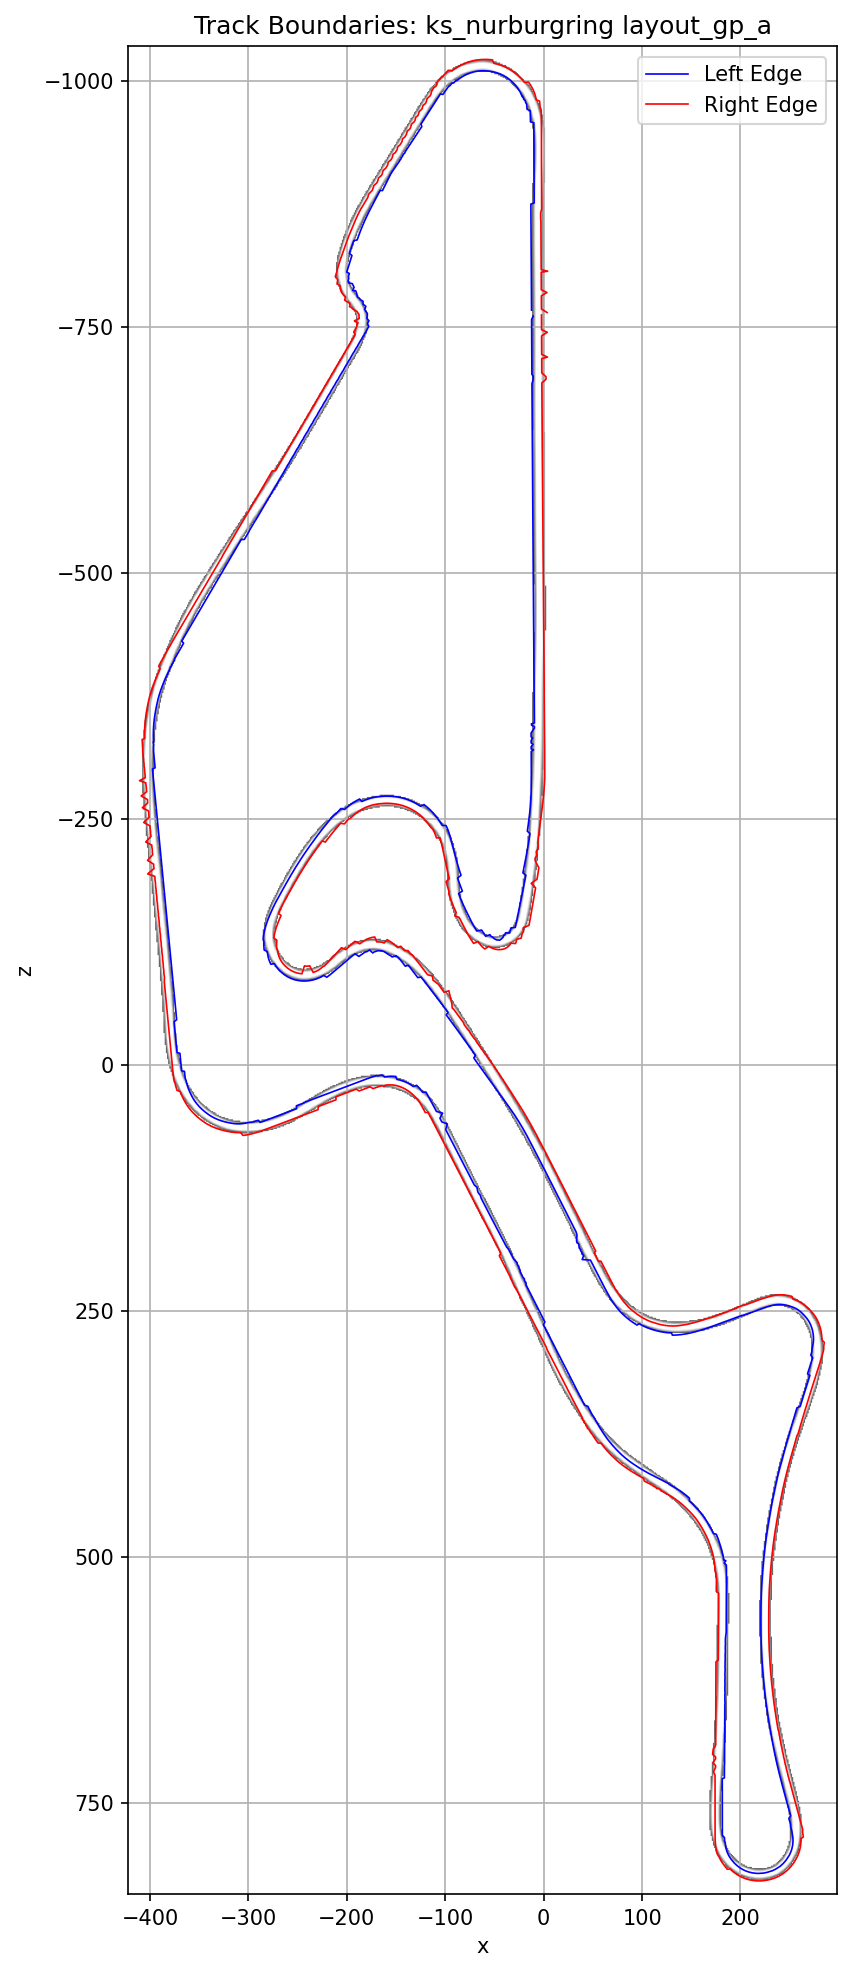

In [9]:
plot_track_edges_with_map(
    edges_df,
    map_image_path="../data/assetto_corsa_tracks/ks_nurburgring/layout_gp_a/map.png",
    offset=(-422, -1035),
    scale=1.2,
    title="Track Boundaries: ks_nurburgring layout_gp_a"
)
